In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

In [2]:
model_path = "../../thesis/models/DescriptorHetero/CH/"

# Molecules 

In [4]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"
basis = "6-311++g**"

data = ScreenedData(r_max=10)

data.include(data_path = "../../thesis/dataset/MethanT/", postfix = "MethanT", target=target)

In [5]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"

data = ScreenedData(r_max=10)

data.include(data_path = "../../thesis/dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../thesis/dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../thesis/dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../thesis/dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../thesis/dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../thesis/dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../thesis/dataset/EthanT3/", postfix = "EthanT3", target=target)
data.include(data_path = "../../thesis/dataset/EthanT4/",  postfix = "EthanT4", target=target)
data.include(data_path = "../../thesis/dataset/EthanT5/",  postfix = "EthanT5", target=target)
data.include(data_path = "../../thesis/dataset/EthanT6/",  postfix = "EthanT6", target=target)

data.include(data_path = "../../thesis/dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../thesis/dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../thesis/dataset/EthenT3/", postfix = "EthenT3", target=target)
data.include(data_path = "../../thesis/dataset/EthenT4/",  postfix = "EthenT4", target=target)
data.include(data_path = "../../thesis/dataset/EthenT5/",  postfix = "EthenT5", target=target)
data.include(data_path = "../../thesis/dataset/EthenT6/",  postfix = "EthenT6", target=target)


data.include(data_path = "../../thesis/dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../thesis/dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../thesis/dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

# Descriptor 

In [3]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
import pickle

model = make_uniform(25, 5, eta_max=60, eta_min=20)

descriptor_C = AtomicNumberWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(4),
    BehlerCutoff1(5)
)


pickle.dump(descriptor_C, open(model_path + "descriptor_C.dump", "wb"))
    
descriptor_C.radial_descriptor.number_of_descriptors, descriptor_C.angular_descriptor.number_of_descriptors, descriptor_C.number_of_descriptors

(25, 50, 75)

In [4]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
import pickle

model = make_uniform(25, 5, eta_max=60, eta_min=20)

descriptor_H = AtomicNumberWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(3),
    BehlerCutoff1(5)
)


pickle.dump(descriptor_H, open(model_path + "descriptor_H.dump", "wb"))
    
descriptor_H.radial_descriptor.number_of_descriptors, descriptor_H.angular_descriptor.number_of_descriptors, descriptor_H.number_of_descriptors

(25, 32, 57)

# Package Dataset 

In [10]:
from SCFInitialGuess.utilities.dataset import make_block_dataset, extract_HETERO_block_dataset_pairs

dataset = make_block_dataset(
    [descriptor_C, descriptor_H],
    data.molecules,
    data.T,
    ["C", "H"],
    extract_HETERO_block_dataset_pairs
)

np.save(model_path + "normalisation.npy", (dataset.x_mean, dataset.x_std))


In [11]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(49416, 12408, 15560)

In [12]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS


dim_C = N_BASIS[basis]["C"]
dim_H = N_BASIS[basis]["H"]

# NN Utils 

In [13]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [14]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath=None, learning_rate=1e-4, log_dir=None):

    if not log_dir is None:
        tensorboard = keras.callbacks.TensorBoard(
            log_dir=log_dir, 
            histogram_freq=0, 
            batch_size=32, 
            #update_freq='epoch'
        )
    
    if not filepath is None:
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath, 
            monitor='val_mean_squared_error', 
            verbose=1, 
            save_best_only=True, 
            save_weights_only=False, 
            mode='auto', 
            period=1
        )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Training 

In [15]:
dataset.training[0].shape, dataset.training[1].shape

((49416, 132), (49416, 154))

In [16]:
descriptor_C.number_of_descriptors, descriptor_H.number_of_descriptors, dim_C * dim_H

(75, 57, 154)

In [17]:
structure = [200, 200]

In [18]:
keras.backend.clear_session()

In [19]:
model = make_model(
    structure=structure,
    input_dim=descriptor_C.number_of_descriptors + descriptor_H.number_of_descriptors,
    output_dim=dim_C * dim_H,
    
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               26600     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 154)               30954     
Total params: 97,754
Trainable params: 97,754
Non-trainable params: 0
_________________________________________________________________


Train on 49416 samples, validate on 12408 samples
Epoch 1/1000
49416/49416 [==============================] - 4s 85us/step - loss: 4.8210e-04 - mean_squared_error: 3.5001e-04 - val_loss: 4.4461e-04 - val_mean_squared_error: 3.1651e-04

Epoch 00001: val_mean_squared_error improved from inf to 0.00032, saving model to ../../thesis/models/DescriptorHetero/CH/model.h5
Epoch 2/1000
49416/49416 [==============================] - 3s 69us/step - loss: 3.0434e-04 - mean_squared_error: 2.5791e-04 - val_loss: 3.1714e-04 - val_mean_squared_error: 2.7634e-04

Epoch 00002: val_mean_squared_error improved from 0.00032 to 0.00028, saving model to ../../thesis/models/DescriptorHetero/CH/model.h5
Epoch 3/1000
49416/49416 [==============================] - 3s 70us/step - loss: 2.7576e-04 - mean_squared_error: 2.2424e-04 - val_loss: 3.1802e-04 - val_mean_squared_error: 2.6742e-04

Epoch 00003: val_mean_squared_error improved from 0.00028 to 0.00027, saving model to ../../thesis/models/DescriptorHetero/CH/


Epoch 00029: val_mean_squared_error did not improve from 0.00023
Epoch 30/1000
49416/49416 [==============================] - 5s 110us/step - loss: 1.6091e-04 - mean_squared_error: 1.4840e-04 - val_loss: 2.3788e-04 - val_mean_squared_error: 2.2537e-04

Epoch 00030: val_mean_squared_error did not improve from 0.00023
Epoch 31/1000
49416/49416 [==============================] - 5s 93us/step - loss: 1.6091e-04 - mean_squared_error: 1.4840e-04 - val_loss: 2.3788e-04 - val_mean_squared_error: 2.2537e-04

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00031: val_mean_squared_error did not improve from 0.00023
Epoch 32/1000
49416/49416 [==============================] - 4s 84us/step - loss: 1.6091e-04 - mean_squared_error: 1.4840e-04 - val_loss: 2.3788e-04 - val_mean_squared_error: 2.2537e-04

Epoch 00032: val_mean_squared_error did not improve from 0.00023
Epoch 33/1000
49416/49416 [==============================] - 5s 99us/step - loss: 1.6091e-04 - m

KeyboardInterrupt: 

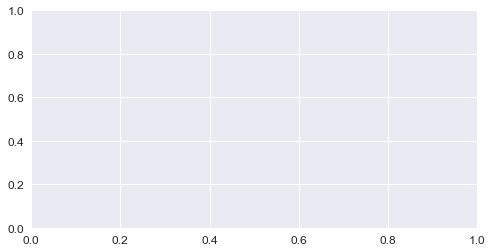

In [20]:
train_model(
    model, 
    dataset, 
    model_path + "model.h5",
    learning_rate=1e-3,
    #log_dir=None#"./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)